In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import smact
import umap
from matplotlib.ticker import FixedLocator, FormatStrFormatter
from scipy.special import rel_entr
from scipy.stats import energy_distance, pearsonr, spearmanr, wasserstein_distance
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from AtomicEmbeddings.core import Embedding

sns.set(font_scale=2)

/Users/aonwu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up the Atomic Embedding features

# Create a list of the CBFVs we are interested in
cbfvs = ["mat2vec", "random_200", "magpie_sc", "megnet16"]

# Create a dictionary of {cbfv: AtomicEmbeddings}
AtomEmbeds = {cbfv: Embedding.load_data(cbfv) for cbfv in cbfvs}

# Only keep the first 83 elements for the Atomic Embeddings

# For now Smact is used, but a future update will aim to remove this dependency
el_symbols = smact.ordered_elements(1, 83)

# Iterate over the AtomEmbeds to remove the elements

for cbfv in cbfvs:

    # Get the keys of the atomic embeddings object
    elements = set(AtomEmbeds[cbfv].element_list)
    el_symbols_set = set(el_symbols)

    # Get the element symbols we want to remove
    els_to_remove = list(elements - el_symbols_set)

    # Iteratively delete the elements with atomic number
    # greater than 83 from our embeddings
    for el in els_to_remove:
        del AtomEmbeds[cbfv].embeddings[el]

    # Verify that we have 83 elements
    print(len(AtomEmbeds[cbfv].element_list))

83
81
83
83


In [21]:
df_mag = AtomEmbeds["magpie_sc"].create_correlation_df()
# df_mag=df_mag.loc[df_mag.pearson_corr!=1].reset_index(drop=True)
print(df_mag.shape)
df_mag.head()

(6889, 6)


,ele_1,ele_2,mend_1,mend_2,euclid_dist,pearson_corr
0,H,H,"(103.0, H)","(103.0, H)",0.000000,1.000000
1,H,He,"(103.0, H)","(1.0, He)",6.192168,0.690324
2,He,H,"(1.0, He)","(103.0, H)",6.192168,0.690324
3,H,Li,"(103.0, H)","(12.0, Li)",5.195304,0.565271
4,Li,H,"(12.0, Li)","(103.0, H)",5.195304,0.565271


In [22]:
df_meg = AtomEmbeds["megnet16"].create_correlation_df()
# df_meg=df_meg.loc[df_meg.pearson_corr!=1].reset_index(drop=True)
print(df_meg.shape)
df_meg.head()

(6889, 6)


,ele_1,ele_2,mend_1,mend_2,euclid_dist,pearson_corr
0,H,H,"(103.0, H)","(103.0, H)",0.000000,1.000000
1,H,He,"(103.0, H)","(1.0, He)",1.569139,0.559426
2,He,H,"(1.0, He)","(103.0, H)",1.569139,0.559426
3,H,Li,"(103.0, H)","(12.0, Li)",1.661745,0.385986
4,Li,H,"(12.0, Li)","(103.0, H)",1.661745,0.385986


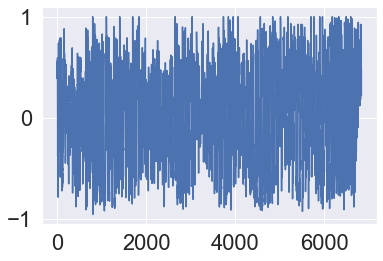

In [13]:
fig, ax = plt.subplots()

ax.plot(df_meg["pearson_corr"])
plt.show()

In [23]:
meg_pearson = df_meg["pearson_corr"].to_numpy()
mag_pearson = df_mag["pearson_corr"].to_numpy()

In [32]:
energy_distance(meg_pearson, mag_pearson)

0.1263035743181485

In [26]:
df_meg["meg-mag_pearson"] = abs(meg_pearson - mag_pearson)
df_meg.head()

,ele_1,ele_2,mend_1,mend_2,euclid_dist,pearson_corr,meg-mag_pearson
0,H,H,"(103.0, H)","(103.0, H)",0.000000,1.000000,1.110223e-16
1,H,He,"(103.0, H)","(1.0, He)",1.569139,0.559426,1.308977e-01
2,He,H,"(1.0, He)","(103.0, H)",1.569139,0.559426,1.308977e-01
3,H,Li,"(103.0, H)","(12.0, Li)",1.661745,0.385986,1.792855e-01
4,Li,H,"(12.0, Li)","(103.0, H)",1.661745,0.385986,1.792855e-01


In [27]:
df_meg.describe()

,euclid_dist,pearson_corr,meg-mag_pearson
count,6889.000000,6889.000000,6889.000000
mean,1.552086,0.033295,0.373498
std,0.602602,0.498729,0.276747
min,0.000000,-0.958521,0.000000
25%,1.157201,-0.378623,0.150934
50%,1.506974,0.028368,0.323033
75%,1.887631,0.437189,0.549683
max,4.194940,1.000000,1.516616


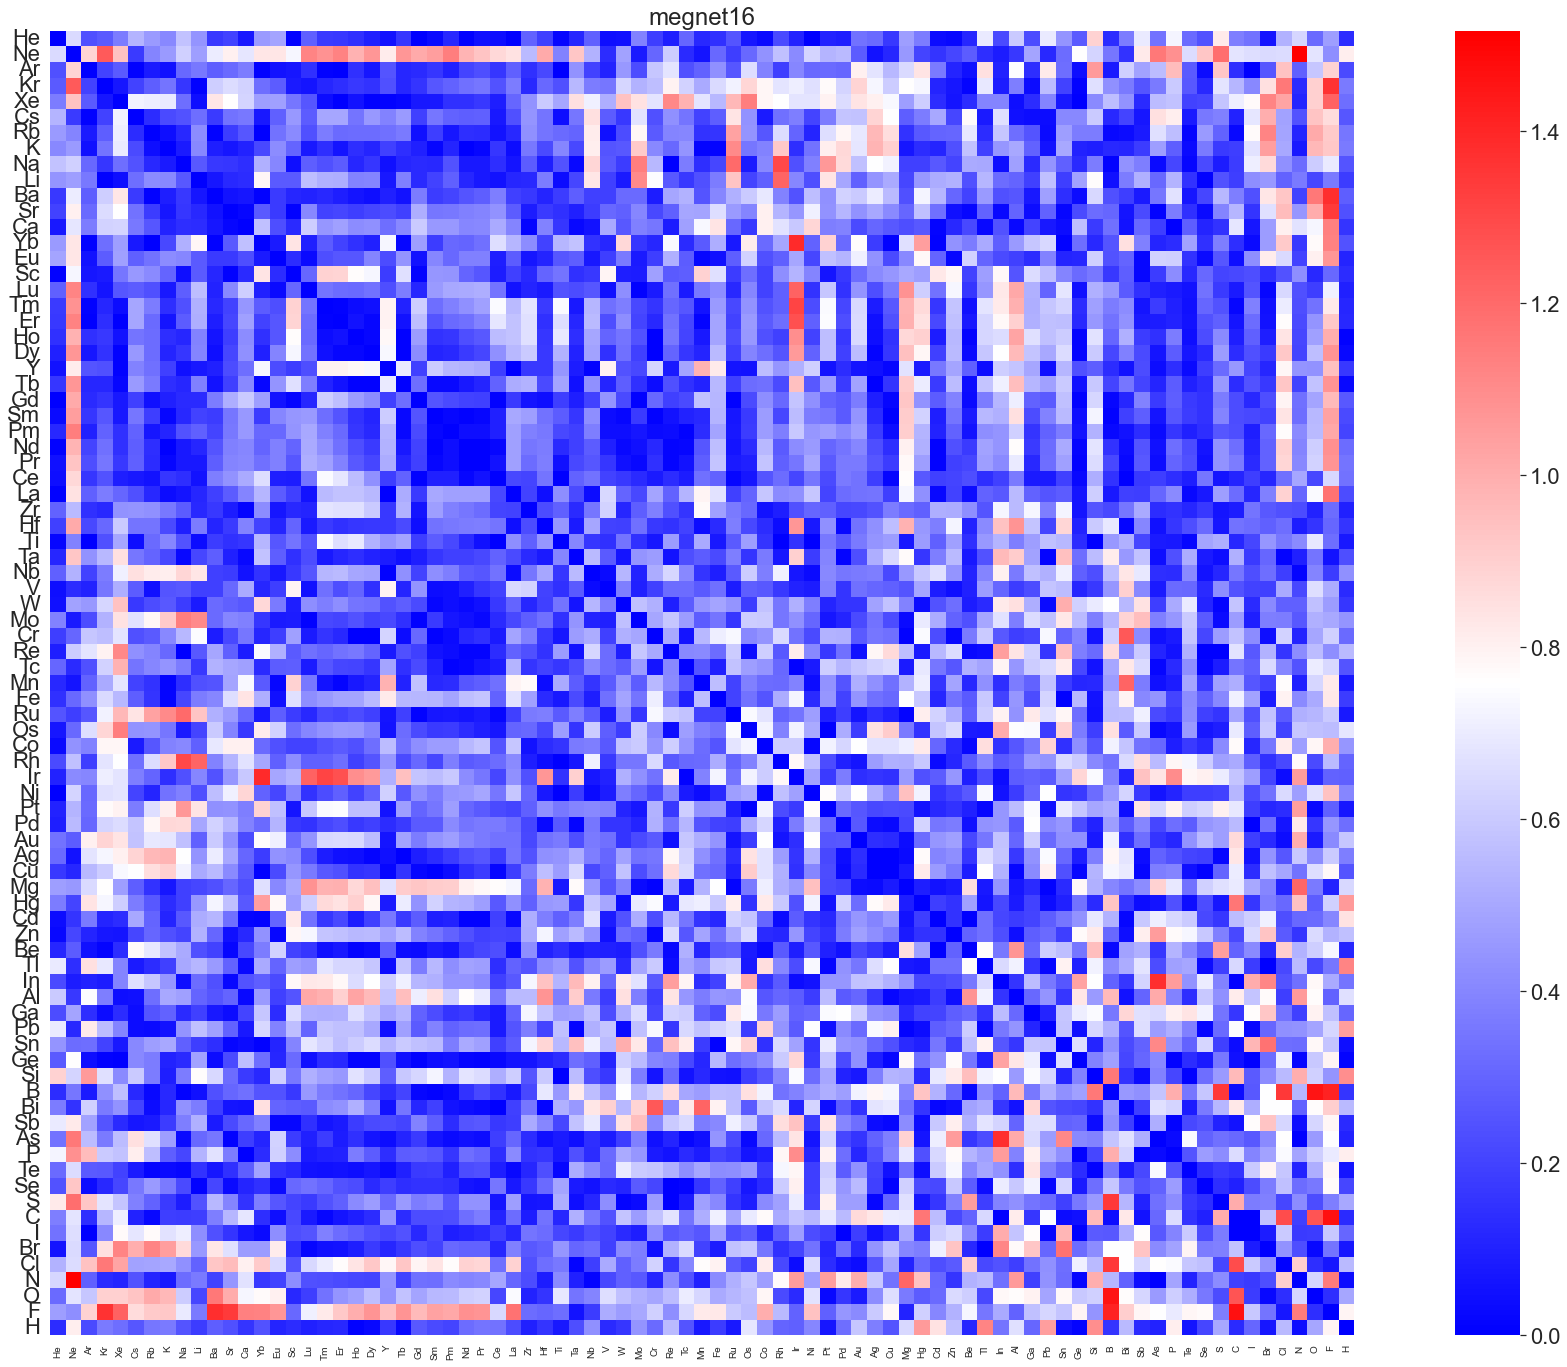

In [30]:
fig, ax = plt.subplots(figsize=(36, 24))
p = df_meg.pivot_table(values="meg-mag_pearson", index="mend_1", columns="mend_2")

xlabels = [i[1] for i in p.index]
ylabels = [i[1] for i in p.columns]
g = sns.heatmap(
    p,
    cmap="bwr",
    square="True",
    linecolor="k",
    ax=ax,
    xticklabels=True,
    yticklabels=True,
)
ax.title.set_text(cbfv)
# ax.set_xticklabels(xlabels, fontsize="medium")
ax.set_yticklabels(ylabels)
majors = np.linspace(1, 83, 2)
minors = np.linspace(2, 83, 2)
# ax.xaxis.set_major_locator(FixedLocator())
ax.set_xlabel("")
ax.set_ylabel("")

plt.show()